# Parameters

In [1]:
RUN = 164
SUBRUN = 0
Nevents = 10 # number of events we are going to extract to plot

root = "/home/juan/projects/lst_camera_validation/plot_on_camera/data/20240416"

path0 = root + "/LST-4.1.Run"+str(160).zfill(5)+"."+str(SUBRUN).zfill(4)+".fits.fz"
path1 = root + "/LST-4.1.Run"+str(RUN).zfill(5)+"."+str(SUBRUN).zfill(4)+".fits.fz"
path2 = root + "/LST-4.2.Run"+str(RUN).zfill(5)+"."+str(SUBRUN).zfill(4)+".fits.fz"
path1

'/home/juan/projects/lst_camera_validation/plot_on_camera/data/20240416/LST-4.1.Run00164.0000.fits.fz'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy             as np
from protozfits import File
from traitlets.config      import Config
from ctapipe.io            import EventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame

import graphs
indexes = graphs.INDEX_ORDER_PX

source  = EventSource(input_url=path0, max_events=1)
camgeom = source.subarray.tel[1].camera.geometry

import auxiliar as aux
aux.parameters()

def event_pedestals_plot(event_index, pedestals,camgeom, ev_ids, ax, cmap='plasma', title="", labcb="charge"):
    
    camdisplay =CameraDisplay(camgeom.transform_to(EngineeringCameraFrame()),ax=ax,
                                image=pedestals[event_index],show_frame=False,cmap=cmap,
                              title=f'{title} Event '+str(ev_ids[event_index]))
    camdisplay.add_colorbar(label=labcb,ax=ax)


    ax.invert_yaxis()
    ax.invert_xaxis()

def sort_based(x_array, ref_array):

    return np.array([x for ref, x in sorted(zip(ref_array, x_array))])

def event_waveforms_plot(event_index, waveforms, ax, ccc="b", titley=""):
 
    aux.parameters()
    
    for px in range(len(waveforms[event_index])):
        
        # random blue color
        if  ccc == "b":
            color = (np.random.choice(np.linspace(0.2,0.5,10)),np.random.choice(np.linspace(0,1,10)),
                     np.random.choice([0.7,0.8,0.9,1]))
        else:
            color = (
                np.random.choice(np.linspace(0.7, 1, 10)),
                np.random.choice(np.linspace(0, 0.4, 10)),
                np.random.choice(np.linspace(0, 0.4, 10))
            )            
        # plot the waveforms
        ax.plot(waveforms[event_index][px], color=color, alpha=0.5, lw=1.5)

    ax.set_xlabel('t (ns)')
    ax.set_ylabel('charge '+titley)

In [3]:
ev_ids = []
pedestalsL = []
stdsL = []
pedestalsH = []
stdsH = []

############
path = path1

file = File(path)

events = []
for i in range(Nevents):
    ev_ids.append(file.Events[i].event_id)
    events.append(file.Events[i])

wsL, wsH = [], []
for ev in events:
    tot_ws = ev.waveform

    _array_arrayL, _array_arrayH = [], []
    for i in range(1855):
        _arrayL, _arrayH = [], []
        for j in range(40):
            _arrayL.append(tot_ws[i * 40 + j])
            _arrayH.append(tot_ws[1855 * 40 + i * 40 + j])
        _array_arrayL.append(_arrayL[5:])
        _array_arrayH.append(_arrayH[5:])
    
    wsL.append(np.array(_array_arrayL))
    wsH.append(np.array(_array_arrayH))

for w in wsL:
    _p, _s = [], []
    for _w in w:
        _p.append(np.mean(_w))
        _s.append(np.std(_w))
    pedestalsL.append(np.array(sort_based(_p, indexes)))
    stdsL.append(np.array(sort_based(_s, indexes)))
for w in wsH:
    _p, _s = [], []
    for _w in w:
        _p.append(np.mean(_w))
        _s.append(np.std(_w))
    pedestalsH.append(np.array(sort_based(_p, indexes)))
    stdsH.append(np.array(sort_based(_s, indexes)))

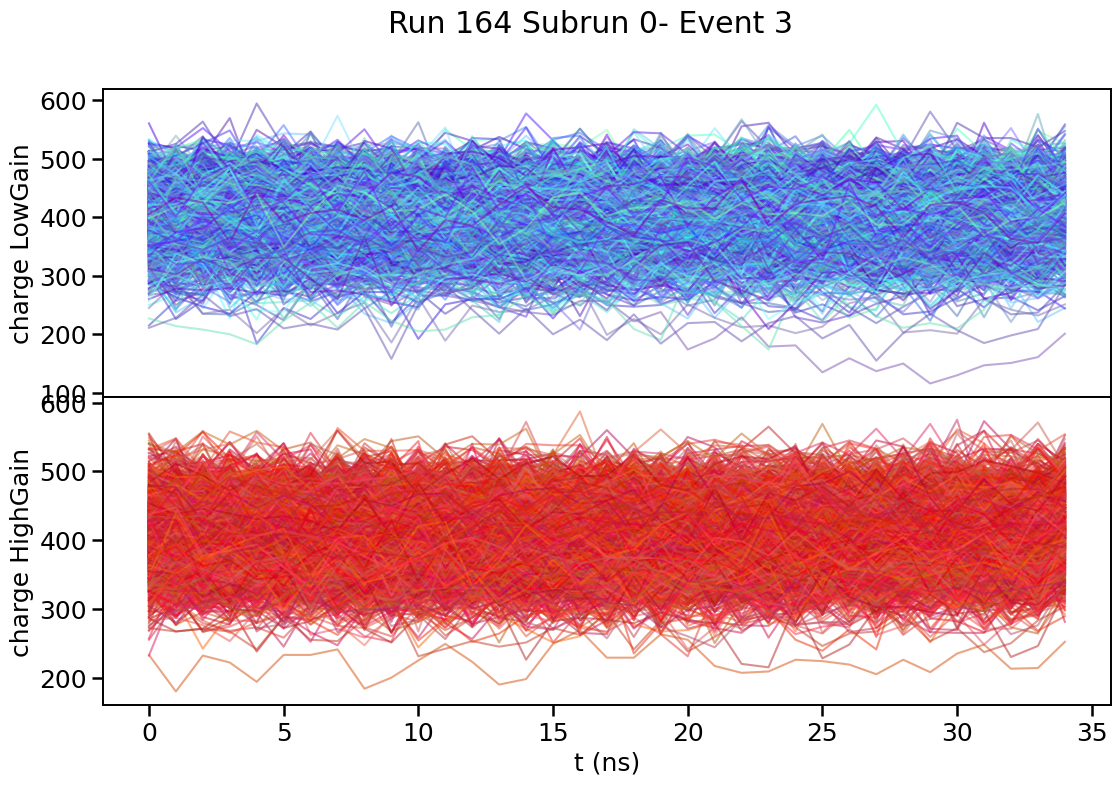

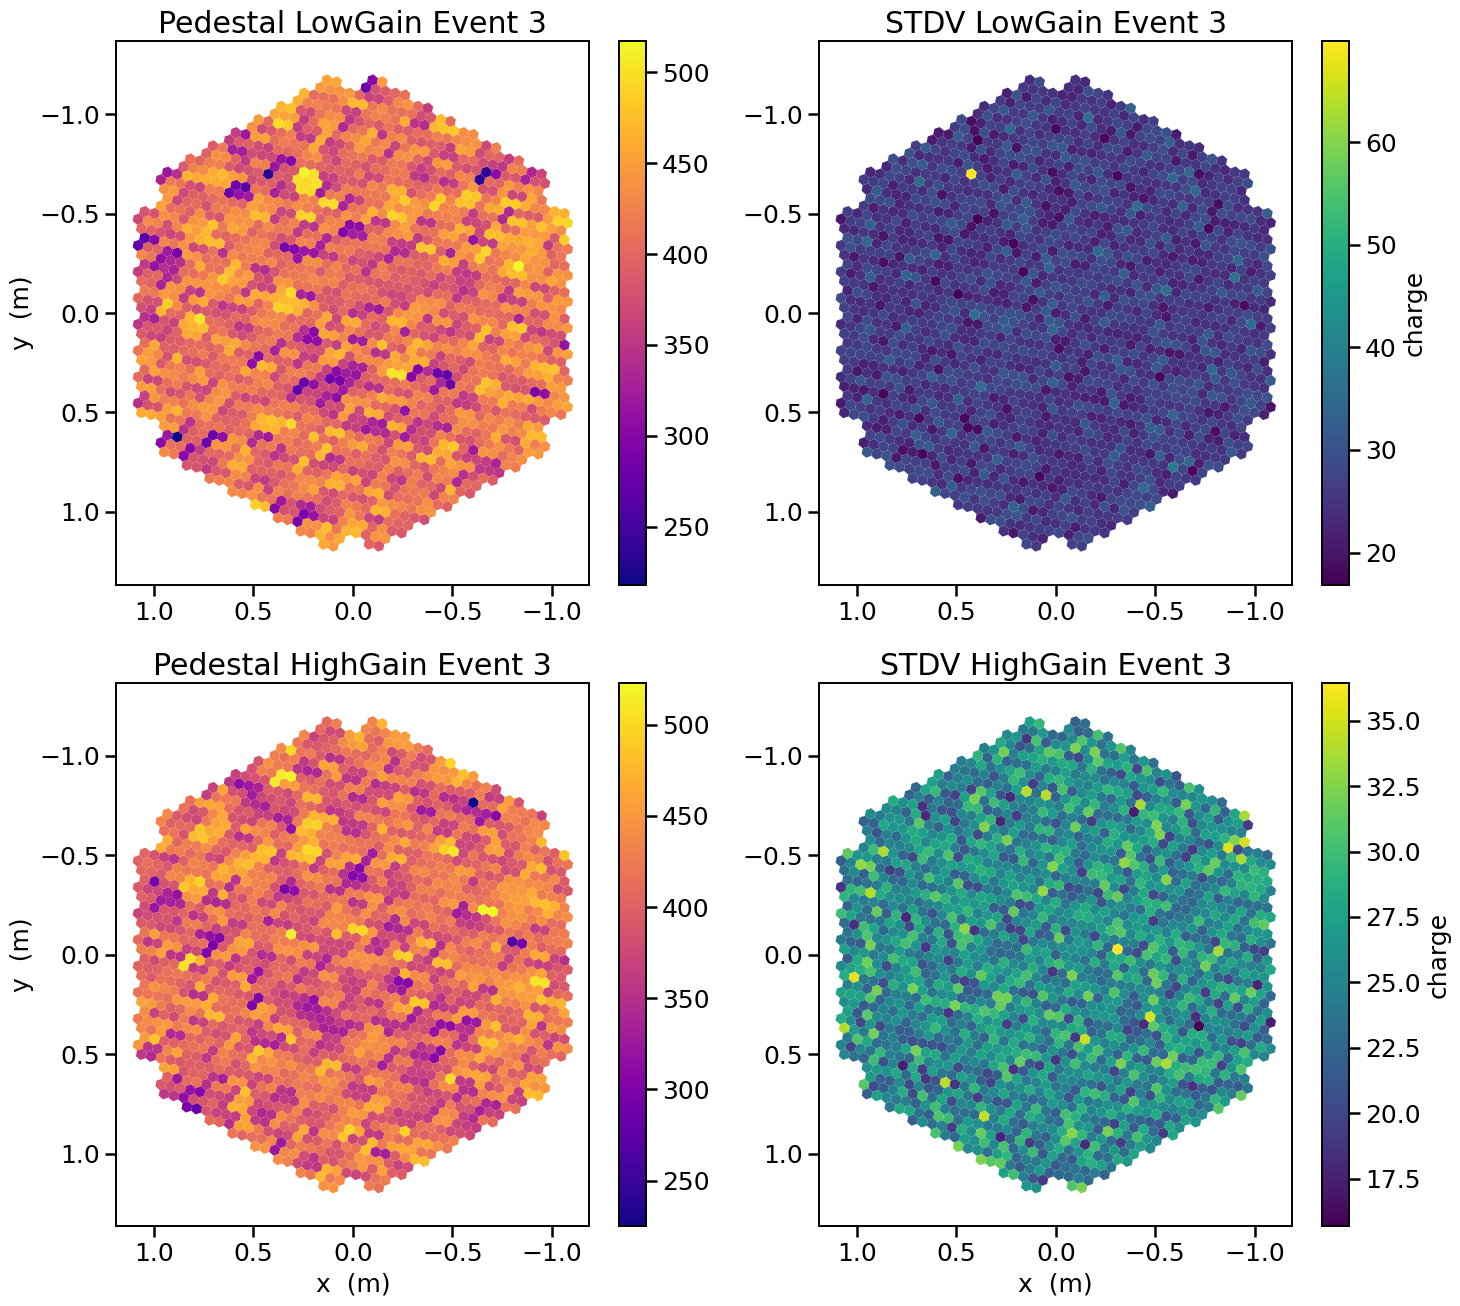

In [6]:
for event_index in range(len(wsH)):

    fig,(ax, ax2) = plt.subplots(2, 1, figsize=(13,8), sharex=True)   
    event_waveforms_plot(event_index, wsL, ax, "b", "LowGain")
    event_waveforms_plot(event_index, wsH, ax2, "r", "HighGain")
    fig.suptitle(f"Run {RUN} Subrun {SUBRUN}- Event {ev_ids[event_index]}")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f'graphs/run{RUN}_ev{event_index}_waveforms.png', format='png', bbox_inches='tight', dpi=300) 
    plt.show()




    
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,13.4))       
    
    event_pedestals_plot(event_index, pedestalsL, camgeom, ev_ids, ax1, "plasma", "Pedestal LowGain", "")
    event_pedestals_plot(event_index, stdsL, camgeom, ev_ids, ax2, "viridis", "STDV LowGain", "charge")
    event_pedestals_plot(event_index, pedestalsH, camgeom, ev_ids, ax3, "plasma", "Pedestal HighGain", "")
    event_pedestals_plot(event_index, stdsH, camgeom, ev_ids, ax4, "viridis", "STDV HighGain", "charge")

    for ax in [ax2, ax4]:
        ax.set_ylabel(None)
    for ax in [ax2, ax1]:
        ax.set_xlabel(None)

    fig.tight_layout()
    plt.savefig(f'graphs/run{RUN}_ev{event_index}_cameraplot.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
ev_ids = []
for ii, path in enumerate([path1, path2]):
    file = File(path)
    _ev_ids = []
    for i in range(len(file.Events)):
        if i%1000 == 0:
            print(f"Stream {ii+1}: {i}/{len(file.Events)} - {i/len(file.Events) * 100:.2f}%")
        _ev_ids.append(file.Events[i].event_id)

    ev_ids = [*ev_ids, *_ev_ids]

ev_ids_sort = np.sort(ev_ids)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(np.arange(len(ev_ids_sort)), ev_ids_sort)
ax2.plot(np.arange(len(ev_ids_sort)-1), np.diff(ev_ids_sort), color="r")
ax2.set_xlabel("# event")
ax1.set_ylabel("event ID")
ax2.set_ylabel("dN/d#")
ax1.grid()
ax2.grid()
plt.subplots_adjust(wspace=0, hspace=0)
ax1.set_xlim(0, len(ev_ids_sort))
plt.show()